<a href="https://colab.research.google.com/github/kaya-atakan/natural-language-understanding/blob/main/GloVe_NLU_Slot_filling_and_Intent_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%javascript
function ClickConnect(){
    console.log("Clicked on connect button"); 
    document.querySelector("colab-connect-button").click()
}
setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

In [2]:
import sys
import spacy
import random
import time
import numpy as np
import pandas as pd

# from google.colab import drive
# drive.mount('/content/drive')


In [3]:
!ls

sample_data


In [4]:
!git clone https://github.com/cntogz/NotAs.git

Cloning into 'NotAs'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 75 (delta 18), reused 42 (delta 10), pack-reused 0
Unpacking objects: 100% (75/75), done.


In [5]:
%cd NotAs/SNIPS/

/content/NotAs/SNIPS


In [6]:
!wget http://nlp.stanford.edu/data/glove.6B.zip 

--2020-12-08 17:27:47--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-12-08 17:27:47--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-12-08 17:27:47--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [7]:
!ls && pwd

glove.6B.zip  test  train  valid
/content/NotAs/SNIPS


In [8]:
!unzip -q glove.6B.zip

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from pathlib import Path

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam

In [10]:
lines_train = Path('train').read_text('utf-8').strip().splitlines()


In [11]:
def parse_line_to_dict(line):
  """
  input: string
  """
  slot_data, intent_label = line.split(" <=> ")
  items = slot_data.split()
  words = [item.rsplit(':', 1)[0] for item in items]
  word_labels = [item.rsplit(':', 1)[1] for item in items]
  
  return {
      'intent_label': intent_label,
      'words': " ".join(words),
      'words_label': " ".join(word_labels),
      'length': len(words)
    }

# parse_line_to_dict(lines_train[0])

In [12]:
lines_validation = Path('valid').read_text('utf-8').strip().splitlines()
lines_test = Path('test').read_text('utf-8').strip().splitlines()


df_train = pd.DataFrame([parse_line_to_dict(line) for line in lines_train])
df_validation = pd.DataFrame([parse_line_to_dict(line) for line in lines_validation])
df_test = pd.DataFrame([parse_line_to_dict(line) for line in lines_test])

In [13]:
unique_word_vocab = df_train['words'].str.split(' ',expand=True).stack().unique().tolist()

In [14]:
unique_word_vocab_lower = [element.lower() for element in unique_word_vocab]

In [15]:
df_train.intent_label.value_counts(normalize=True)

GetWeather              0.145216
PlayMusic               0.145216
BookRestaurant          0.143152
SearchScreeningEvent    0.142082
RateBook                0.141853
SearchCreativeWork      0.141700
AddToPlaylist           0.140783
Name: intent_label, dtype: float64

In [16]:
first_sentence = df_train.iloc[0]['words']
print(first_sentence)

-Add Don and Sherri to my Meditate to Sounds of Nature playlist


KERAS GLOVE EMBEDDINGS

In [17]:
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Concatenate,Dense, TimeDistributed
from keras.layers import Flatten
from keras.layers.embeddings import Embedding

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from keras.preprocessing.text import Tokenizer

Tokenizer utility class which can vectorize a text corpus into a list of integers. Each integer maps to a value in a dictionary that encodes the entire corpus, with the keys in the dictionary being the vocabulary terms themselves

In [18]:
# tokenizer = keras.preprocessing.text.Tokenizer(num_words=len(unique_word_vocab_lower))
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(df_train['words'])

In [19]:
len(word_tokenizer.word_index)

11182

It is important to note that the index 0 is reserved and is not assigned to any word. This zero index is used for padding

In [20]:
vocab_size = len(word_tokenizer.word_index) + 1 ## Adding 1 because of reserved 0 index


In [21]:
train_embedded_sentences = word_tokenizer.texts_to_sequences(df_train['words'])
val_embedded_sentences = word_tokenizer.texts_to_sequences(df_validation['words'])
test_embedded_sentences = word_tokenizer.texts_to_sequences(df_test['words'])
# print(embedded_sentences)

In [22]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

word_count = lambda sentence: len(word_tokenize(sentence))
longest_sentence = max(df_train['words'], key=word_count)
length_long_sentence = len(word_tokenize(longest_sentence))

train_padded_sentences = pad_sequences(train_embedded_sentences, 45, padding='post')
val_padded_sentences = pad_sequences(val_embedded_sentences, 45, padding='post')
test_padded_sentences = pad_sequences(test_embedded_sentences, 45, padding='post')

print(train_padded_sentences)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[[  12  613   24 ...    0    0    0]
 [  73  414 4433 ...    0    0    0]
 [  12    1   77 ...    0    0    0]
 ...
 [ 245    5   81 ...    0    0    0]
 [ 177   81   45 ...    0    0    0]
 [  17   21   83 ...    0    0    0]]


In [23]:
lines_glove = Path('glove.6B.100d.txt').read_text('utf-8').strip().splitlines()


In [24]:
import os
path_to_glove_file = os.getcwd() + '/glove.6B.100d.txt'

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [25]:
def slot_encoder(text_sequences, slot_names, tokenizer, slot_map, max_length):
    encoded = np.zeros(shape=(len(text_sequences), max_length), dtype=np.int32)
    
    for i, (text_sequence, word_labels) in enumerate(zip(text_sequences, slot_names)):
        
        encoded_labels = []
        
        for word, word_label in zip(text_sequence.split(), word_labels.split()):
            tokens = word_tokenize(word) #Now, instead of BERT's tokenizer, I rely on NLTK's tokenizer
            encoded_labels.append(slot_map[word_label]) #word to index
        encoded[i, 1:len(encoded_labels) + 1] = encoded_labels
    
    return encoded

In [26]:
word_tokenize(df_train['words_label'].iloc[0])

['O',
 'B-entity_name',
 'I-entity_name',
 'I-entity_name',
 'O',
 'B-playlist_owner',
 'B-playlist',
 'I-playlist',
 'I-playlist',
 'I-playlist',
 'I-playlist',
 'O']

Calculate how many words can be captured by Glove word Embeddings

In [27]:
num_tokens = len(unique_word_vocab_lower) + 1
embedding_dim = 100
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 9853 words (1329 misses)


In [28]:
import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix


In [29]:
EMBEDDING_MATRIX = create_embedding_matrix(path_to_glove_file, word_tokenizer.word_index, embedding_dim=100)

In [30]:
nonzero_elements = np.count_nonzero(np.count_nonzero(EMBEDDING_MATRIX, axis=1))
nonzero_elements / vocab_size

0.8810694804614146

In [31]:
EMBEDDING_MATRIX.shape

(11183, 100)

In [32]:
unique_slot_labels = df_train['words_label'].str.split(' ',expand=True).stack().unique().tolist()

slot_names = ["[PAD]"]
slot_names += unique_slot_labels

slot_map = {}
for label in slot_names:
    slot_map[label] = len(slot_map)

In [33]:
slot_train = slot_encoder(df_train['words'], df_train['words_label'], word_tokenizer, slot_map, 45)
slot_validation = slot_encoder(df_validation['words'], df_validation['words_label'], word_tokenizer, slot_map, 45)
slot_test = slot_encoder(df_test['words'], df_test['words_label'], word_tokenizer, slot_map, 45)

In [34]:
unique_intent_labels = df_train['intent_label'].unique().tolist()
intent_map = dict((label, idx) for idx, label in enumerate(unique_intent_labels))

In [35]:
intent_train = df_train['intent_label'].map(intent_map).values
intent_validation = df_validation['intent_label'].map(intent_map).values
intent_test = df_test['intent_label'].map(intent_map).values

In [36]:
from tensorflow.keras import layers

MAX_LEN = 45 #We know this from BERT task
EMBEDDING_DIM = 100 #Glove's 100 dimensions for word vectors

# Input for variable-length sequences of integers
# inputs = keras.Input(shape=(None,), dtype="int32")

int_sequences_input = keras.Input(shape=(train_padded_sentences.shape[1],), dtype="int32") #int32

embedding_layer = layers.Embedding(vocab_size, EMBEDDING_DIM, 
                                   weights=[EMBEDDING_MATRIX], input_length=MAX_LEN, trainable=False)


# Embed each integer in a 128-dimensional vector
embedded_sequences = embedding_layer(int_sequences_input)

# Add bidirectional LSTM
x = layers.Bidirectional(layers.LSTM(100, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), 
                         merge_mode = 'concat' )(embedded_sequences)
# x = layers.Bidirectional(layers.LSTM(100))(x)


preds_slot = TimeDistributed(layers.Dense(len(slot_map), activation="softmax"))(x) #Slot Classification

"""https://stackoverflow.com/questions/63809090/tensorflow-2-0-invalidargumenterror-assertion-failed-condition-x-y-did-not"""

x = Flatten()(x) #logits and labels must have the same dimension!!!

preds_intent = layers.Dense(len(intent_map), activation="softmax")(x) #Intent Classification

# Create the model
model_multi = keras.Model(inputs=int_sequences_input, outputs=[preds_slot, preds_intent])

print(model_multi.summary())


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 100)      1118300     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 45, 200)      160800      embedding[0][0]                  
__________________________________________________________________________________________________
flatten (Flatten)               (None, 9000)         0           bidirectional[0][0]              
_______________________________________________________________________________________

We use categorical crossentropy as our loss since we're doing softmax classification. Moreover, we use sparse_categorical_crossentropy since our labels are integers.

In [37]:
losses = [SparseCategoricalCrossentropy(from_logits=True),
          SparseCategoricalCrossentropy(from_logits=True)]

model_multi.compile(
    loss=losses, optimizer="adam", metrics=['acc']
)

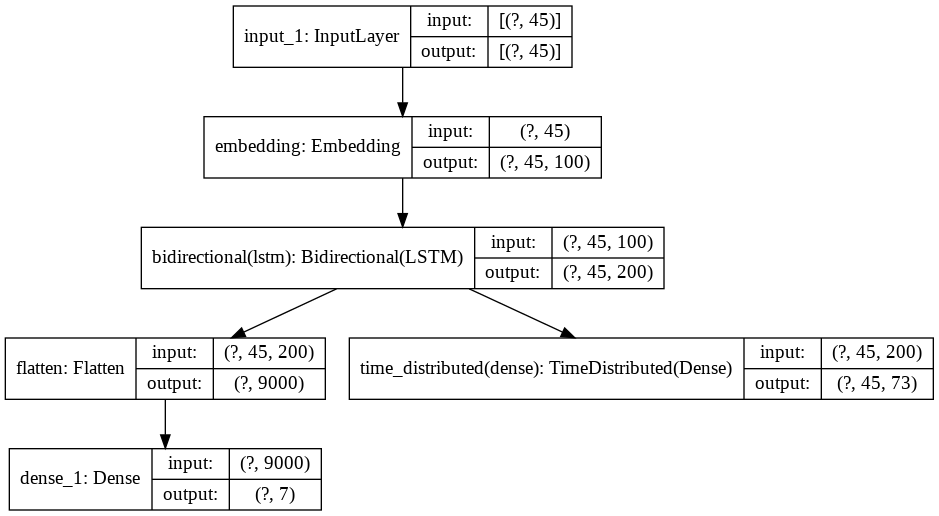

In [38]:
tf.keras.utils.plot_model(model_multi, show_shapes=True, show_layer_names=True)

In [39]:
model_multi.fit(train_padded_sentences, [slot_train, intent_train], batch_size=128, epochs=20, 
                validation_data=(val_padded_sentences, [slot_validation, intent_validation]))


Epoch 1/20
103/103 [==============================] - 39s 376ms/step - loss: 5.2078 - time_distributed_loss: 3.8280 - dense_1_loss: 1.3798 - time_distributed_acc: 0.7386 - dense_1_acc: 0.8199 - val_loss: 4.7286 - val_time_distributed_loss: 3.4610 - val_dense_1_loss: 1.2676 - val_time_distributed_acc: 0.8567 - val_dense_1_acc: 0.9014
Epoch 2/20
103/103 [==============================] - 38s 368ms/step - loss: 4.6809 - time_distributed_loss: 3.4548 - dense_1_loss: 1.2261 - time_distributed_acc: 0.8632 - dense_1_acc: 0.9416 - val_loss: 4.6572 - val_time_distributed_loss: 3.4564 - val_dense_1_loss: 1.2007 - val_time_distributed_acc: 0.8590 - val_dense_1_acc: 0.9657
Epoch 3/20
103/103 [==============================] - 37s 362ms/step - loss: 4.6628 - time_distributed_loss: 3.4511 - dense_1_loss: 1.2118 - time_distributed_acc: 0.8650 - dense_1_acc: 0.9552 - val_loss: 4.6790 - val_time_distributed_loss: 3.4549 - val_dense_1_loss: 1.2241 - val_time_distributed_acc: 0.8602 - val_dense_1_acc: 0.

In [40]:
model_multi.evaluate(test_padded_sentences, [slot_test, intent_test])

22/22 [==============================] - 1s 30ms/step - loss: 4.6314 - time_distributed_loss: 3.4480 - dense_1_loss: 1.1834 - time_distributed_acc: 0.8660 - dense_1_acc: 0.9829


[4.631353855133057,
 3.4479918479919434,
 1.183362364768982,
 0.8660317659378052,
 0.9828571677207947]

In [41]:
report_slot_matrix = np.empty((slot_test.shape[0], slot_test.shape[1]), dtype="object")
reversed_slot_map = dict(map(reversed, slot_map.items()))
for k, v in slot_map.items():
  for i in range(0, slot_test.shape[0]):
    for j in range(0, slot_test.shape[1]):
      report_slot_matrix[i][j] = reversed_slot_map[slot_test[i][j]]


In [42]:
from sklearn.metrics import classification_report

# get the ground truth of your data. 
ground_truth_slot = slot_test
ground_truth_intent = intent_test

# predict the probability distribution of the data
# y_pred = np.around(model_multi.predict(test_padded_sentences))
# y_pred = model_multi.predict(test_padded_sentences)
y_pred_slot = np.around((model_multi.predict(test_padded_sentences))[0])
y_pred_intent = np.around(model_multi.predict(test_padded_sentences)[1])

# get the class with highest probability for each sample
y_pred_slot = np.argmax(y_pred_slot, axis=-1)
y_pred_intent = np.argmax(y_pred_intent, axis=-1)



In [43]:
def get_classification_report(y_test, y_pred):
    '''Source: https://gist.github.com/fclesio/bb5871281debc07d75127552c56b08b5'''
    
    from sklearn import metrics
    report = metrics.classification_report(y_test, y_pred, output_dict=True)
    df_classification_report = pd.DataFrame(report).transpose()
    return df_classification_report

In [44]:
get_classification_report(ground_truth_intent, y_pred_intent)

,precision,recall,f1-score,support
0,1.000000,0.980000,0.989899,100.000000
1,1.000000,1.000000,1.000000,100.000000
2,1.000000,0.980000,0.989899,100.000000
3,1.000000,0.980000,0.989899,100.000000
4,1.000000,1.000000,1.000000,100.000000
5,0.909091,1.000000,0.952381,100.000000
6,0.979167,0.940000,0.959184,100.000000
accuracy,0.982857,0.982857,0.982857,0.982857
macro avg,0.984037,0.982857,0.983037,700.000000
weighted avg,0.984037,0.982857,0.983037,700.000000


In [45]:
get_classification_report(y_pred_slot.reshape(-1), ground_truth_slot.reshape(-1))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.971573,0.965448,0.968501,25064.000000
1,0.906471,0.478869,0.626678,6436.000000
2,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...
71,0.000000,0.000000,0.000000,0.000000
72,0.000000,0.000000,0.000000,0.000000
accuracy,0.866032,0.866032,0.866032,0.866032
macro avg,0.026829,0.020633,0.022788,31500.000000
